# Exploratory Data Analysis

The goal of this JuPyter notebook is to explore and analyze various possible features for the Quora Insincere Question challenge hosted on Kaggle.  The challenge aims to classify questions into 0 (sincere) and 1 (insincere) questions to better flag insincere questions asked on the website.  The challenge can be found here: https://www.kaggle.com/c/quora-insincere-questions-classification .

## Imports

We start by importing useful libraries and the dataset itself.  Since we are looking at questions asked on Quora, there will naturally be a lot of Natural Language Processing libraries here from NLTK and spaCy.

In [1]:
# import useful stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import string
from collections import Counter

# track progress
from tqdm import tqdm

# NLTK
# vader sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# spaCy
import spacy
import plac
from spacy.attrs import ORTH
import io
from spacy.lang.en.stop_words import STOP_WORDS

C:\Users\AFKsi\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


The "train.csv" file is imported below.  Since we are doing an EDA, we don't have to worry about the "test.csv" file.  Espcially considering that there are no targets assigned in that file anyway.

In [2]:
# get files
train = pd.read_csv("train.csv")
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


## Minor Cleanup

We can drop the "qid" column because we know that will never contribute anything to the model.  This also makes the dataset smaller and more compact to work with.

In [3]:
# drop the qid column, we already know this contributes absolutely nothing to us here
train.drop("qid", axis = 1, inplace = True)
train.head()

,question_text,target
0,How did Quebec nationalists see their province...,0
1,"Do you have an adopted dog, how would you enco...",0
2,Why does velocity affect time? Does velocity a...,0
3,How did Otto von Guericke used the Magdeburg h...,0
4,Can I convert montra helicon D to a mountain b...,0


And we check for any missing data that we might want to take a look at before the analysis itself.

In [4]:
# missing data check
train.apply(lambda x: sum(x.isnull()), axis=0)

question_text    0
target           0
dtype: int64

## Distributions

We start by taking a quick look at the distribution of the targets in the dataset.  This gives us an idea at what we are looking at.

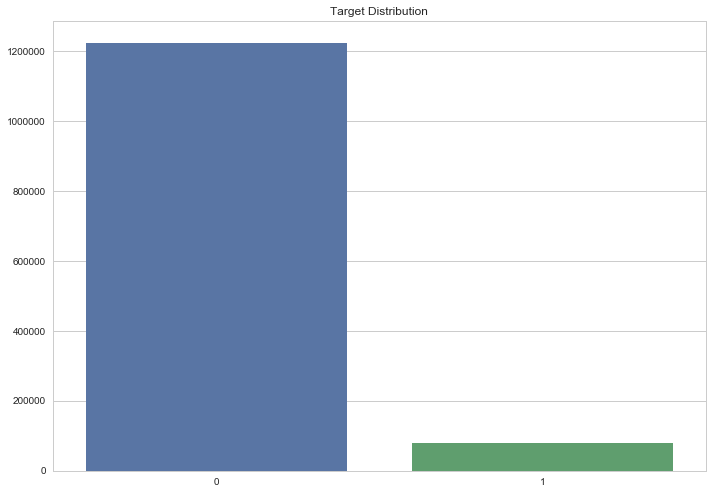

In [30]:
# target distribution as whole numbers
# set the seaborn style
sns.set(style = "whitegrid", rc = {"figure.figsize":(11.7, 8.27)})

# count of targets
target_count = train["target"].value_counts()

# barplot of distribution
ax = sns.barplot(x = target_count.index, y = target_count.values, data = train).set_title("Target Distribution")

In [6]:
# easy to read statement
print("There are", target_count[0], "sincere questions and", target_count[1], "insincere questions in the training dataset.")

There are 1225312 sincere questions and 80810 insincere questions in the training dataset.


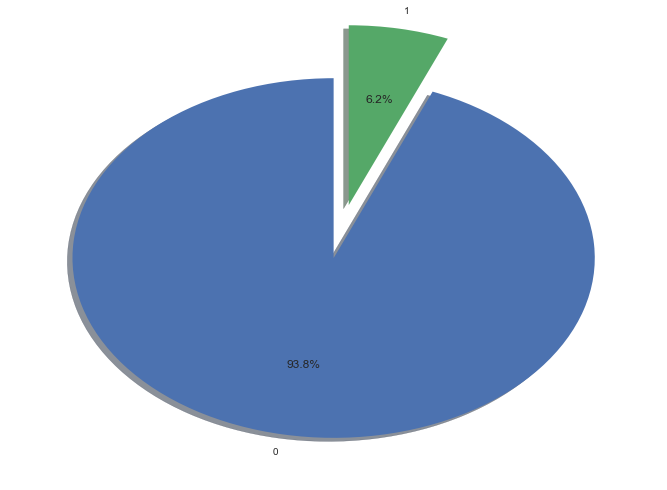

<Figure size 842.4x595.44 with 0 Axes>

In [10]:
# matplotlib because seaborn doesn't have a piechart option :(
labels = ["0", "1"]
values = [target_count[0], target_count[1]]
explode = (0, 0.3)

ax1 = plt.pie(values, labels = labels, explode = explode, shadow = True, startangle = 90, autopct = "%.1f%%")
figure(figsize = (11.7, 8.27))

plt.show()

Amusingly, if we took the test dataset and simply said everything was 0, we would classify >90% of the questions correctly.  But that would defeat the purpose of the challenge.

## Sentiment Analysis

One thing I've wondered about is whether there is a difference in sentiment between insincerely asked questions and sincerely asked ones.  For example, imagine someone asking "Why are Jews so evil?" which would have a negative sentiment versus a relatively neutral sentiment from a question such as "Who came up with the Heliocentrism idea?"

To analyze this, we make use of the Vader Sentiment Analyzer found in the NLTK library.

In [44]:
# insincere questions have a certain tone to them that is different from sincere questions
# can we make a useful feature out of this?
analyzer = SentimentIntensityAnalyzer()

# create a function to iterate over the whole dataset
def question_sentiment(question):
    result = analyzer.polarity_scores(question)
    score = result["compound"]
    return round(score, 2)

In [65]:
# example to check things
example = train["question_text"][1234]
example_target = train["target"][1234]
print(example)
print("Sentiment of the example:", question_sentiment(example))
print("Target:", example_target)

Why does everyone assume the NFL kneelers have a right to free speech? That right is not protected by employees from employers by 1st amendment.
Sentiment of the example: 0.22
Target: 1


In [67]:
# iterate over the whole dataset to produce another column of values
train["sentiment_value"] = train["question_text"].apply(question_sentiment)
train.head()

,question_text,target,sentiment_value
0,How did Quebec nationalists see their province...,0,0.00
1,"Do you have an adopted dog, how would you enco...",0,0.61
2,Why does velocity affect time? Does velocity a...,0,0.00
3,How did Otto von Guericke used the Magdeburg h...,0,0.00
4,Can I convert montra helicon D to a mountain b...,0,0.00


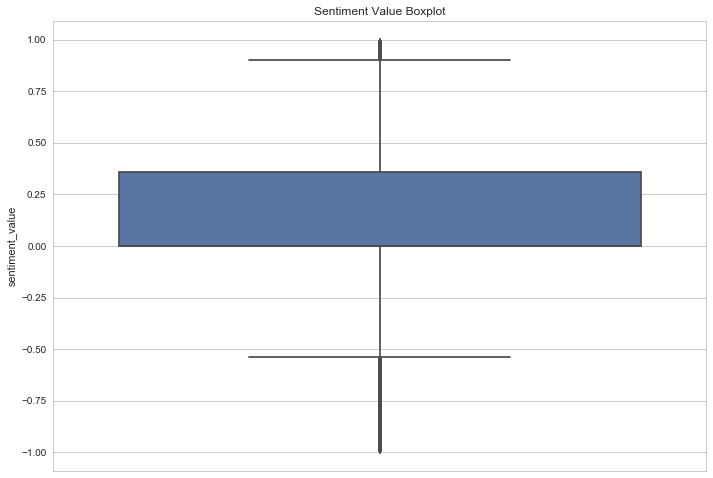

In [71]:
# overall boxplot of sentiments
ax2 = sns.boxplot(y = "sentiment_value", data = train).set_title("Sentiment Value Boxplot")

Overall sentiment appears to be quite neutral, with a large number of outliers.  We should take a look at the sentiment of the different target questions.

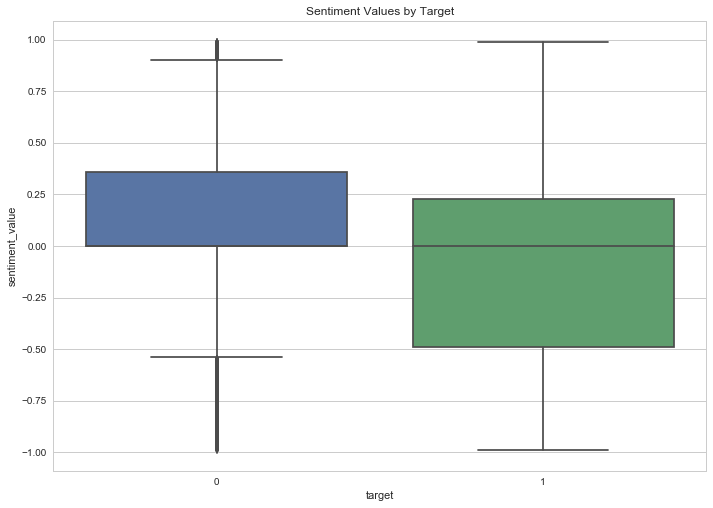

In [72]:
# boxplots by target, is there a difference between them?
ax3 = sns.boxplot(x = "target", y = "sentiment_value", data = train).set_title("Sentiment Values by Target")

The means are about the same, but the interquartile range is bigger for insincere questions and there are fewer outliers as well.  This might not be a big enough difference to include in a model.  On the other hand, the sentiment range of sincere questions is smaller than that of the insincere questions so it might be worth saying that any sentiment value above or below a certain range is more likely to be insincere.

## Lemmatization

To further analyze the text of the data, we need to lemmatize it, or reduce words to their base form.  While we're at it, we can also process the data by removing punctuation and stop words.

In [5]:
# load the english module for spacy
nlp = spacy.load('en_core_web_sm', disable = ["ner"])

# write a function to process the text
def process_text(text):
    text = text.translate(str.maketrans('','',string.punctuation))   # remove punctuation from the text
    text = nlp(text)   # runs spaCy on the text
    lemmatized = list()   # initialize a list to hold our lemmas
    for word in text:
        lemma = word.lemma_.strip()   # remove white space at the start and end of text just in case it exists
        if lemma:
            if not STOP_WORDS or (STOP_WORDS and lemma not in STOP_WORDS):   # do not append lemma if it is a stop word
                lemmatized.append(lemma)  
    return " ".join(lemmatized)

In [6]:
# example
example = process_text(train["question_text"][1234])
example

'assume nfl kneeler right free speech right protect employee employer 1st amendment'

In [7]:
# iterate over the whole column of interest
tqdm.pandas()
lemmatized_question_text = train["question_text"].progress_apply(process_text)

100%|██████████| 1306122/1306122 [2:08:11<00:00, 169.82it/s] 


In [10]:
# take a look at the results
lemmatized_question_text.head()

0       quebec nationalist -PRON- province nation 1960
1    -PRON- adopt dog -PRON- encourage people adopt...
2    velocity affect time velocity affect space geo...
3           otto von guericke use magdeburg hemisphere
4    -PRON- convert montra helicon d mountain bike ...
Name: question_text, dtype: object

In [11]:
# add to the original dataset so we don't forget/lose it somehow...
# also means we don't work on the original lemmatized data, so we won't need to rerun it if we make a mistake down the line
train["lemmatized_text"] = lemmatized_question_text
train.head()

,question_text,target,lemmatized_text
0,How did Quebec nationalists see their province...,0,quebec nationalist -PRON- province nation 1960
1,"Do you have an adopted dog, how would you enco...",0,-PRON- adopt dog -PRON- encourage people adopt...
2,Why does velocity affect time? Does velocity a...,0,velocity affect time velocity affect space geo...
3,How did Otto von Guericke used the Magdeburg h...,0,otto von guericke use magdeburg hemisphere
4,Can I convert montra helicon D to a mountain b...,0,-PRON- convert montra helicon d mountain bike ...


## Individual Word Frequencies

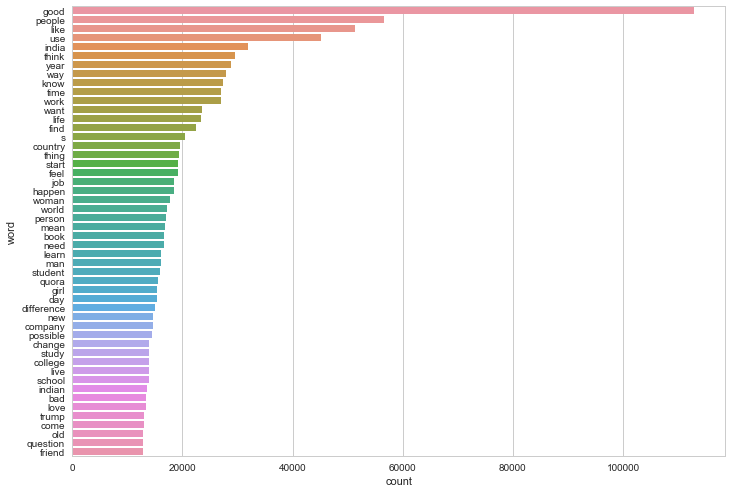

<Figure size 842.4x595.44 with 0 Axes>

In [41]:
# 50 most common words overall
# 51 because the -PRON- is useless to look at
most_common = Counter(" ".join(train["lemmatized_text"]).split()).most_common(51) 

# convert to dataframe for ease of use
most_common_df = pd.DataFrame(most_common)
most_common_df.columns = ["word", "count"]
most_common_df.drop(most_common_df.index[0], inplace = True) # drop the row with -PRON-

# plot everything
ax4 = sns.barplot(x = "count", y = "word", data = most_common_df)

# garbage
del most_common, most_common_df

In [22]:
# should look at the targets individually
# split the dataset into targets 0 and 1
train_0 = train[train["target"] == 0]
train_1 = train[train["target"] == 1]

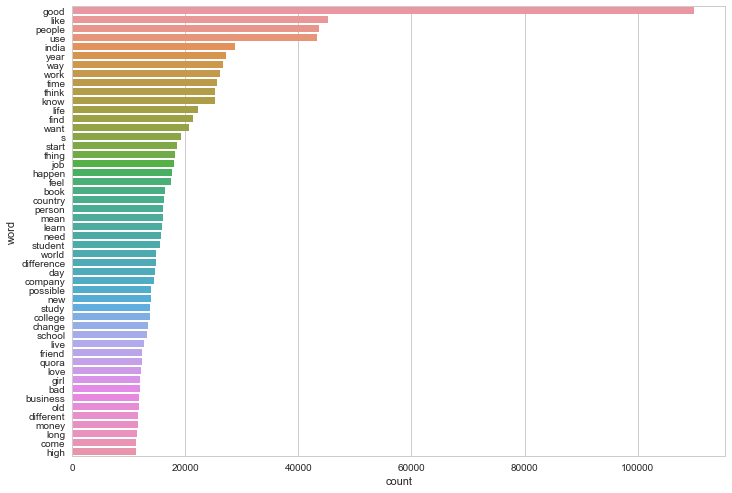

In [40]:
# most common words in train_0
most_common_0 = Counter(" ".join(train_0["lemmatized_text"]).split()).most_common(51)

# convert to dataframe for ease of use
most_common_0_df = pd.DataFrame(most_common_0)
most_common_0_df.columns = ["word", "count"]
most_common_0_df.drop(most_common_0_df.index[0], inplace = True) # drop the row with -PRON-

# plot everything
ax5 = sns.barplot(x = "count", y = "word", data = most_common_0_df)

# garbage
del most_common_0, most_common_0_df

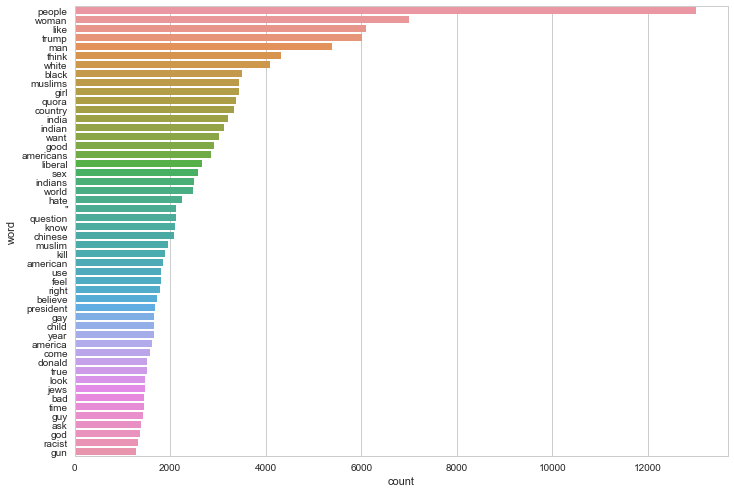

In [47]:
# most common words in train_1
most_common_1 = Counter(" ".join(train_1["lemmatized_text"]).split()).most_common(51)

# convert to dataframe for ease of use
most_common_1_df = pd.DataFrame(most_common_1)
most_common_1_df.columns = ["word", "count"]
most_common_1_df.drop(most_common_1_df.index[0], inplace = True) # drop the row with -PRON-

# plot everything
ax6 = sns.barplot(x = "count", y = "word", data = most_common_1_df)

# garbage
del most_common_1, most_common_1_df

Notice the kinds of words that pop up in insincere questions in comparison?  Like race, guns and sexual orientation.

## Noun Frequencies

Nouns might be better to see what are topics in common with sincere and insincere questions.  So we want to take our processed text and retrieve nouns from it.

In [24]:
# function to reduce the processed text to just nouns
def find_nouns(text):
    text = nlp(text)
    nouns = [token.text for token in text if token.is_stop != True and token.is_punct != True and token.pos_ == "NOUN"]
    return " ".join(nouns)

In [25]:
# testing testing 1 2 3
example = find_nouns(train["lemmatized_text"][1234])
example

'nfl speech employee employer 1st amendment'

In [26]:
# apply to the dataset
tqdm.pandas()
nouns_text = train["lemmatized_text"].progress_apply(find_nouns)

100%|██████████| 1306122/1306122 [1:58:37<00:00, 183.52it/s] 


In [27]:
# checking
nouns_text.head()

0                       quebec province nation
1                    dog encourage people shop
2        velocity time velocity space geometry
3            guericke use magdeburg hemisphere
4    convert helicon mountain bike change tyre
Name: lemmatized_text, dtype: object

In [28]:
# combine to train
train["nouns_text"] = nouns_text

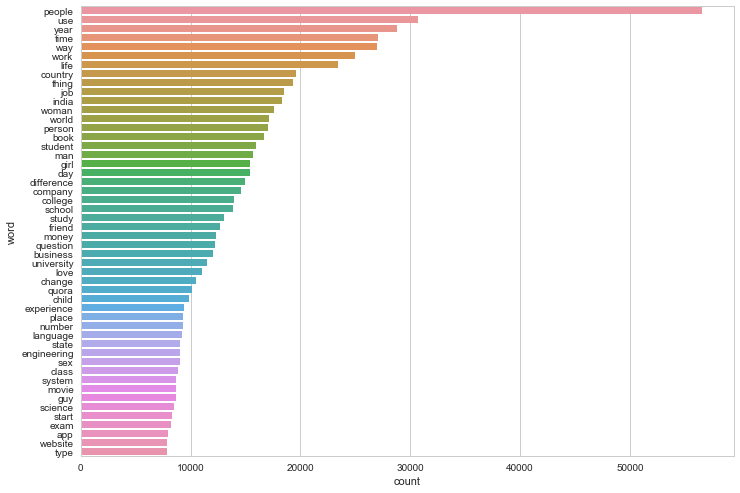

In [32]:
# overall noun frequency graph
common_nouns = Counter(" ".join(train["nouns_text"]).split()).most_common(51)

# convert to dataframe for ease of use
common_nouns_df = pd.DataFrame(common_nouns)
common_nouns_df.columns = ["word", "count"]
common_nouns_df.drop(common_nouns_df.index[0], inplace = True) # drop the row with -PRON-

# plot everything
ax7 = sns.barplot(x = "count", y = "word", data = common_nouns_df)

# garbage
del common_nouns, common_nouns_df

In [38]:
# split by targets
train_0 = train[train["target"] == 0]
train_1 = train[train["target"] == 1]

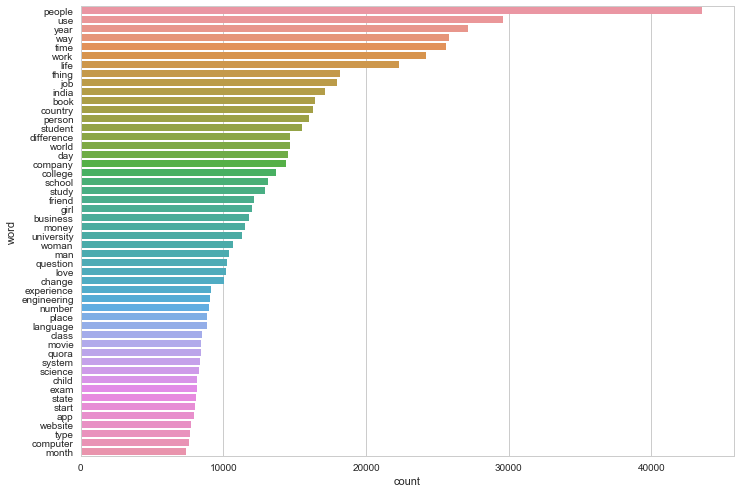

In [35]:
# target 0 nouns
common_nouns_0 = Counter(" ".join(train_0["nouns_text"]).split()).most_common(51)

# convert to dataframe for ease of use
common_nouns_0_df = pd.DataFrame(common_nouns_0)
common_nouns_0_df.columns = ["word", "count"]
common_nouns_0_df.drop(common_nouns_0_df.index[0], inplace = True) # drop the row with -PRON-

# plot everything
ax8 = sns.barplot(x = "count", y = "word", data = common_nouns_0_df)

# garbage
del common_nouns_0_df, train_0

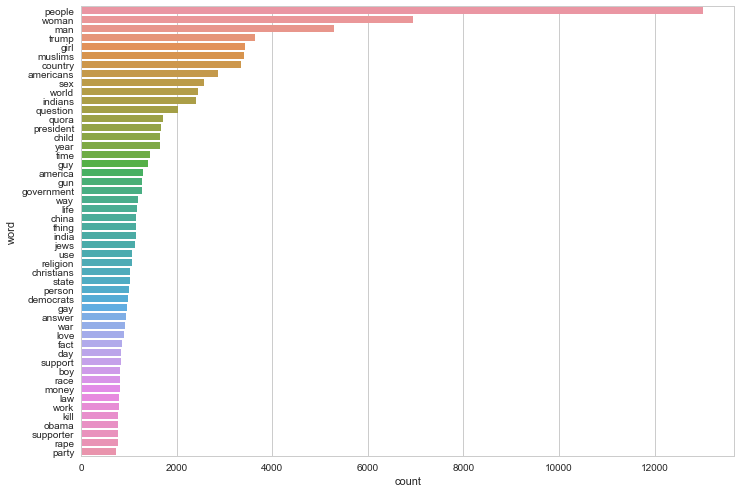

In [39]:
# target 1 nouns
common_nouns_1 = Counter(" ".join(train_1["nouns_text"]).split()).most_common(51)

# convert to dataframe for ease of use
common_nouns_1_df = pd.DataFrame(common_nouns_1)
common_nouns_1_df.columns = ["word", "count"]
common_nouns_1_df.drop(common_nouns_1_df.index[2], inplace = True) # drop the row with -PRON-

# plot everything
ax9 = sns.barplot(x = "count", y = "word", data = common_nouns_1_df)

# garbage
del common_nouns_1_df, train_1

## Bigram Frequencies

In [ ]:
# generate the most frequent bigrams from our lemmatized data


In [40]:
# save session?
import dill
dill.dump_session('notebook_env.db')